## CLASSIFICATION of SPEECH FRAMES using DNNs in TORCH
+ ###### Author: Bob Van Dyck and Dirk Van Compernolle   
+ ###### Modification History: 25/04/2022, 19/03/2023.8.3, 14/03/2025
+ ###### Requires:  pyspch>=0.8

## PURPOSE

This notebook demonstrates the construction of a simple DNN Classifier of Speech Frames.

This notebook is primarily meant for students with little or no prior exposure to DNN learning and to familiarize them with some common concepts and nomenclature, such as network architecture, hidden layers, gradient descent, learning rate, mini-batch learning, ....    

We use the pytorch toolkit.


In [1]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

### 1. Setting up

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import io, os, sys
import logging
import urllib.request

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import torch
from scipy.fftpack import dct

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)

# logging (see pyspch.nn.train())
logging.basicConfig(level=logging.WARNING)
# pyspch
import pyspch
import pyspch.nn
from pyspch.stats import GMM
import pyspch.core as Spch

# 
from pyspch.core.utils_clf import train_GMM, train_MLP, test_clf
from pyspch.core.utils_timit import load_timit_data, print_dataset_statistics, select_subset

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

In [4]:
# choose the colors you like :)
palette = sns.color_palette("bright")
# palette=['red','green','blue','orange','brown','black','dodgerblue','mediumturquoise','cyan','violet','gold','salmon'] 
# sns.palplot(palette)
sns.set_palette(palette)

### 2. The Database 

We are first loading the TIMIT database (SI sentences only).
In the next cell we then select a subcorpus of that in 2 ways:      
- select a subset of classes (timit41 is the full database, other options are vowel3, vowel6, plosives)   
- by downsampling (default by factor of 10, this will be approximate) and subject to a mincount per class (approximate as well)

In [5]:
def extract_Xy(data):
    X = data.get_features_as_numpy()
    y = data.get_labels_as_numpy()
    return(X,y)
#
alphabet = 'timit41'
# The suffix specifies a predefined subcorpus of TIMIT
suffix = "_si"
timit41 = pyspch.timit.get_timit_alphabet('timit41')
ftrs = "mel24"  # "mfcc13", "mel24" or "mel80" are available
modify_feature_args = {} # {"Norm":"meanvar","Deltas":"delta", "n_cep":24}
#
data = load_timit_data(corpus="train"+suffix,ftrs=ftrs,alphabet=alphabet)
#data.modify_features(modify_feature_args)
X_timit_train, y_timit_train = extract_Xy(data)
#
data = load_timit_data(corpus="test"+suffix,ftrs=ftrs,alphabet=alphabet)
data.modify_features(modify_feature_args)
X_timit_test, y_timit_test = extract_Xy(data)

In [6]:
timit41 = pyspch.timit.get_timit_alphabet('timit41')
vowel3=['iy','aa','uw']
vowel6=['iy','aa','uw','ih','eh','er']
plosives=['p','t','k','b','d','g']

In [7]:
classes = vowel3
downsample = 10
mincount=512
X_train, y_train = select_subset(X_timit_train,y_timit_train,labels=classes,downsample=downsample,mincount=mincount)
X_test, y_test = select_subset(X_timit_test,y_timit_test,labels=classes,downsample=downsample,mincount=mincount)
print("STATISTICS for TIMIT SUBCORPUS (%s), downsampled(%d) "%(suffix,downsample))
print_dataset_statistics(y_train,Details=True,txt="Train Database")
print_dataset_statistics(y_test,Details=True,txt="Test Database")

STATISTICS for TIMIT SUBCORPUS (_si), downsampled(10) 
Statistics for Train Database:
Number of classes 3
Number of samples 3427
Minimun/Maximum number of samples per class:  629  /  1830
[('aa', 968), ('iy', 1830), ('uw', 629)]
Statistics for Test Database:
Number of classes 3
Number of samples 1950
Minimun/Maximum number of samples per class:  595  /  733
[('aa', 595), ('iy', 733), ('uw', 622)]


In [8]:
from sklearn.decomposition import PCA

# A. Filterbank Energies (spectral features)
FB_train = X_train
FB_test = X_test
#(FB_train, FB_test, y_train, y_test) = pyspch.core.load_data('tinytimit')
#classes = ['aa','iy','uw']

# B. PCA features (Principle Component Analysis)
pca = PCA()
T = pca.fit(FB_train)
PCA_train = T.transform(FB_train)
PCA_test = T.transform(FB_test)

# C. Mel-Frequency Cepstral Coefficients
MFCC_train = dct(FB_train, type=2, axis=1, norm='ortho')
MFCC_test = dct(FB_test, type=2, axis=1, norm='ortho')

#### Feature visualization

In [9]:
# Define a number of different Features

# A. Filterbank Energies (spectral features)
dfX = pd.DataFrame(FB_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
FB_df = pd.concat([dfy, dfX], axis=1)

# B. PCA features (Principle Component Analysis)
dfX = pd.DataFrame(PCA_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
PCA_df = pd.concat([dfy, dfX], axis=1)

# C. Mel-Frequency Cepstral Coefficients
dfX = pd.DataFrame(MFCC_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
MFCC_df = pd.concat([dfy, dfX], axis=1)

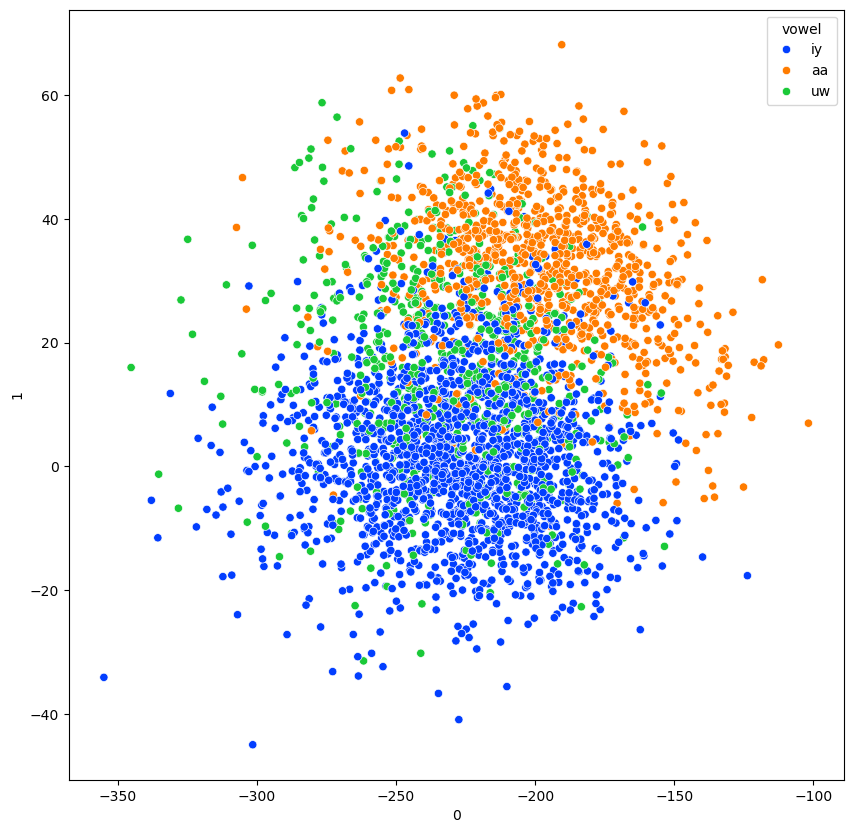

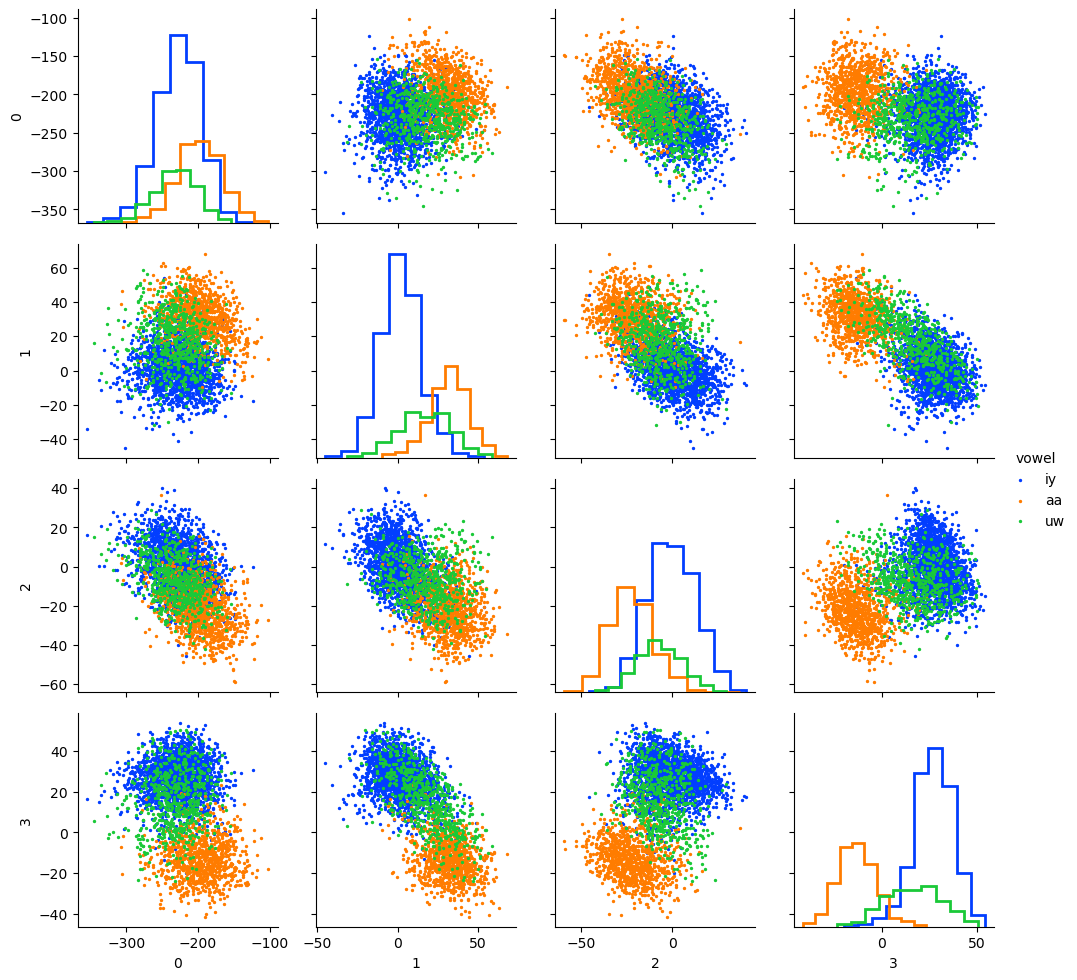

In [10]:
# choose feature set to use in plots and experiments
df = MFCC_df
df.columns = ["vowel","0","1","2","3"]

doPlot = True
if doPlot:
  # plot 2 first dimensions of feature 
  f=plt.figure(figsize=(10, 10))
  sns.scatterplot(data=df, x="0", y="1", hue='vowel')

  # plot all dimensions pairwise
  g = sns.PairGrid(df, hue="vowel")
  g.map_diag(plt.hist, histtype="step", linewidth=2)
  g.map_offdiag(plt.scatter, s=2)
  g.add_legend()

### 3. Setting up a Neural Network in Pytorch

Quite a few helper routines are defined for learning our Neural Network in Pytorch.
There is no need to go through this in detail, but interested people can of course do this.

There are 3 blocks of code:
- definition of classes for the Neural Net and the Data Sets
- training routines
- evalutation routines

In [11]:
# =============================================================================
# Define Classes for Neural network architecture and Data Sets
# =============================================================================

# simple feedforward neural network 
class simple_ffnn(torch.nn.Module):
    
    def __init__(self, in_dim, out_dim, hidden_layer_sizes):
        super(simple_ffnn, self).__init__()

        # attributes
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_layer_sizes = hidden_layer_sizes

        # parameters
        layer_sizes = (in_dim, *hidden_layer_sizes, out_dim)
        layer_sizes_pairwise = [(layer_sizes[i], layer_sizes[i+1]) for 
                                 i in range(len(layer_sizes)-1)]

        # define architecture
        modulelist = torch.nn.ModuleList([])
        for layer_in_size, layer_out_size in layer_sizes_pairwise:
            modulelist.append(torch.nn.Linear(layer_in_size, layer_out_size))
            modulelist.append(torch.nn.Sigmoid())

        # define network as nn.Sequential
        self.net = torch.nn.Sequential(*modulelist)

    def forward(self, x):
        x = self.net(x)
        return x
        
    def init_weights(self):
        self.net.apply(init_normal) 

# weight initialization
def init_normal(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)   
        
# Dataset 
class SimpleDataset(torch.utils.data.Dataset):
    """Simple dataset for easy sampling."""

    def __init__(self, data_X, data_y, labels, labeldict, device):

        # dimensionality
        self.n_samples, self.n_features = data_X.shape
        self.n_classes = len(labels)

        # input data
        self.frames = data_X # (n_samples, n_features)
        self.frames = torch.as_tensor(self.frames, dtype=torch.float32).to(device)

        # labels
        if data_y.dtype != "int64":
            data_y = np.vectorize(labeldict.get)(data_y)
        self.labels = torch.as_tensor(data_y, dtype=torch.long).to(device)

    def split(self, frac=None, seed=None):
        if frac is None:
            return None, self
        else:
            n_split = int(len(self) * frac)
            if seed is not None: torch.manual_seed(seed)
            return torch.utils.data.random_split(self, [n_split, len(self) - n_split])
    

    def __len__(self):
        
        return self.n_samples

    def __getitem__(self, idx):
        frame = self.frames[idx] 
        label = self.labels[idx]
        
        return frame, label

### 4. Experimental setup

- Choose the feature extraction
- Define Network Architecture

In [12]:
# Features (X) and labels (y) used for experiment

# input data
train_X = MFCC_train
test_X = MFCC_test

# define One-Hot Encoding for labels
labels = classes # ["aa", "iy", "uw"]
labeldict = { classes[i]:i for i in range(0,len(labels)) }   #{ "aa" : 0, "iy" : 1, "uw" : 2} 
inv_labeldict = {v : k for k, v in labeldict.items()}

# encode labels
train_y = np.vectorize(labeldict.get)(y_train).astype(np.int64)
test_y = np.vectorize(labeldict.get)(y_test).astype(np.int64)

In [13]:
# network dimensions
in_dim = train_X.shape[1]
out_dim = len(classes)
hidden_layer_sizes = [512,512]

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Dataset and Dataloader for easy sampling mini-batches

# construct dataset
train_ds = SimpleDataset(train_X, train_y, labels, labeldict, device)
test_ds = SimpleDataset(test_X, test_y, labels, labeldict, device)

# construct dataloader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

### Gradient descent: batch vs. mini-batch vs mini-batch with early stopping

We created a test setup in which 4 settings are compared: 2 are batch, one is mini-batch and the last is mini-batch with early stopping

A few things to investigate:
- full batch training converges slower than mini-batch training: you can change the number of epochs, change number of epochs to see how 'cross entropy loss converges'
- cross entropy loss is a good training criterion, but you may observe that 'full convergence' on the optimization criterion (CE) is not the same as 'full convergence' on error rate on independent test set; again change n_epochs to evaluate this

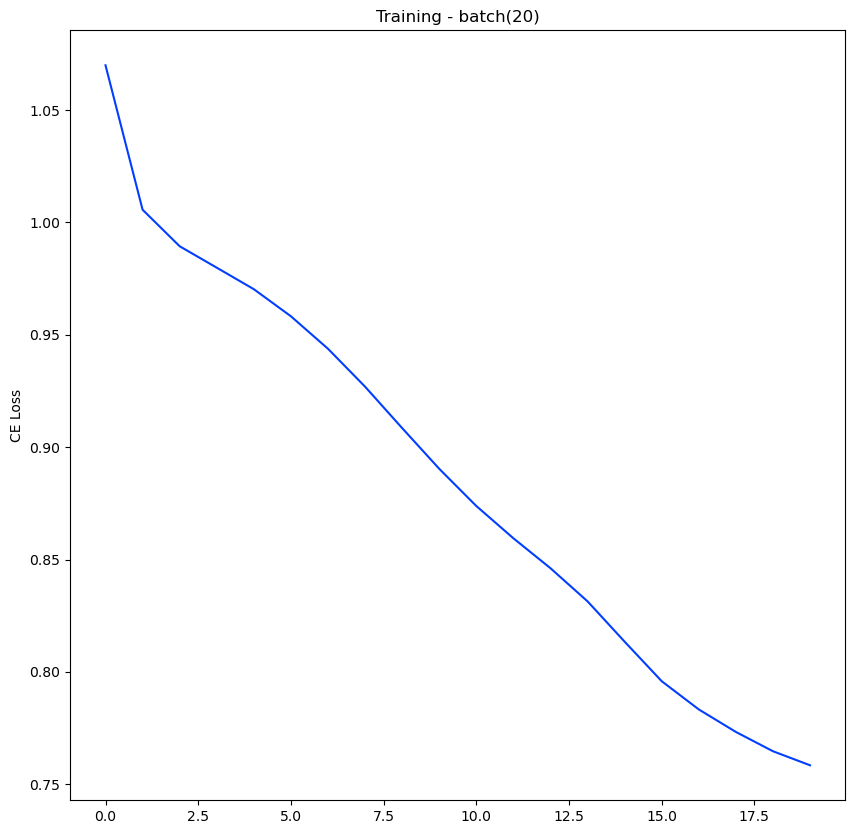

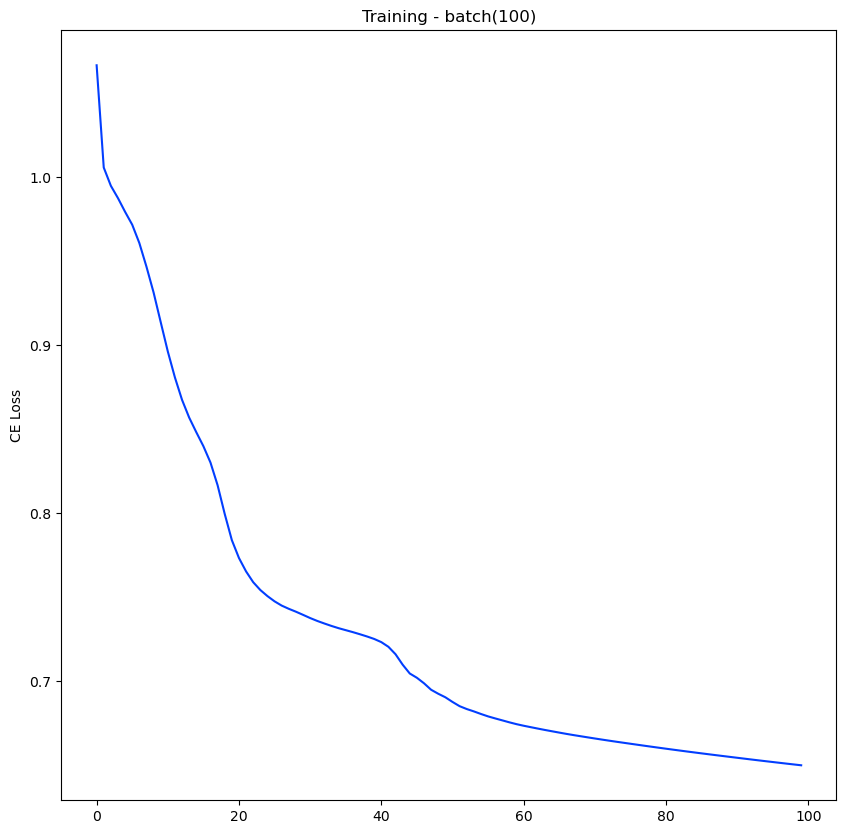

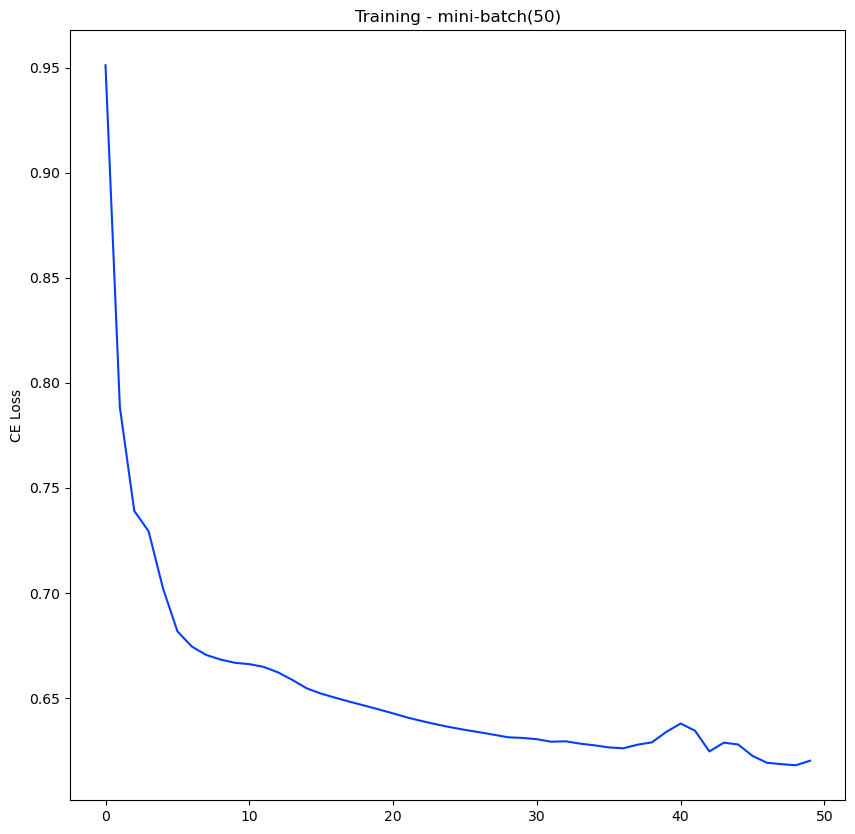

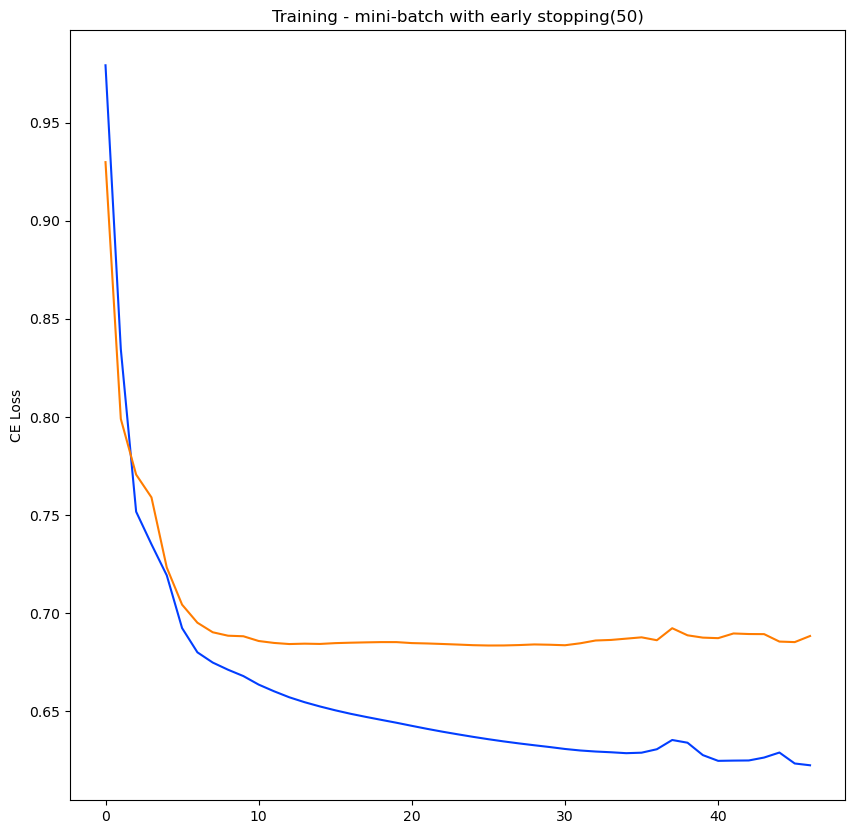

In [15]:
# general training setup
# n_epochs = 10
lr = 0.001
print_every = 1
seed = 1234

criterion = torch.nn.CrossEntropyLoss() # loss function [applies softmax()]
clip_args = None # gradient clipping
scheduler = None # learning rate scheduler

# variations
n_epochs = [20,100, 50, 50]
batch_sizes = [2400, 2400, 128, 128] # 2400 = full batch
patiences = [float('inf'), float('inf'), float('inf'), 20]
val_fracs = [0, 0, 0, 0.1]
names = ['batch', 'batch', 'mini-batch', 'mini-batch with early stopping']

models = []
train_dicts = []
eval_dicts = []

for n_epoch, batch_size, patience, val_frac, name in zip(n_epochs, batch_sizes, patiences, val_fracs, names):
    
    # initialize model & optimizer
    current_epoch = 0
    model = simple_ffnn(in_dim=in_dim, out_dim=out_dim, hidden_layer_sizes=hidden_layer_sizes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # ties model-parameters to optimizer (back-propagation)

    # dataset and validation split
    train_ds = SimpleDataset(train_X, train_y, labels, labeldict, device)
    valid_ds, train_ds = train_ds.split(val_frac, seed)
    
    # dataloaders 
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
    if valid_ds: valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size)
    else: valid_dl = None
    
    # train
    train_loss, val_loss, end_epoch = pyspch.nn.train(model, train_dl, 
        criterion, optimizer, 
        clip_args, scheduler,
        current_epoch, n_epoch, 
        valid_dl, patience, print_every)
    
    # plot training loss
    plt.figure()
    plt.plot(train_loss)
    if valid_ds: plt.plot(val_loss)
    plt.title("Training - " + name + '('+ str(n_epoch)+')')
    plt.ylabel("CE Loss")
    
    # save training
    models.append(model)
    train_dicts.append({'train': train_loss, 'val': val_loss, 'epoch': end_epoch})


BATCH
PER 0.34 and PER per phone class [0.0191 0.0588 1.    ]
CE Loss 0.87


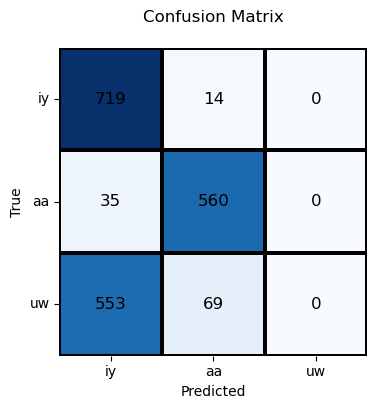

BATCH
PER 0.18 and PER per phone class [0.0559 0.042  0.455 ]
CE Loss 0.72


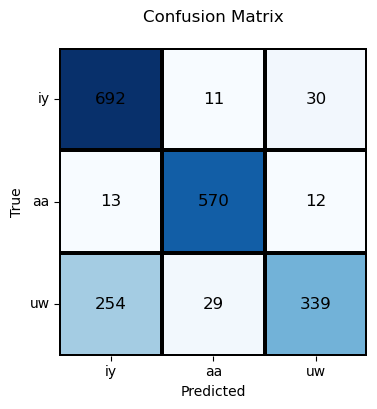

MINI-BATCH
PER 0.16 and PER per phone class [0.1146 0.0403 0.3408]
CE Loss 0.71


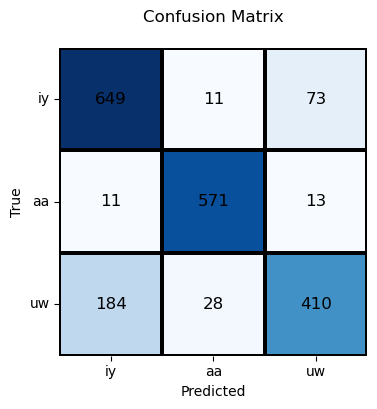

MINI-BATCH WITH EARLY STOPPING
PER 0.18 and PER per phone class [0.0641 0.042  0.4486]
CE Loss 0.73


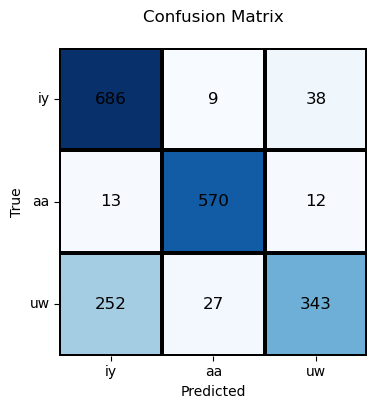

In [16]:
for model, name in zip(models, names):
    
    print(name.upper())
    
    # Confusion matrix
    cm = pyspch.nn.evaluate_cm(model, test_dl) 

    # Phone Error Rate (PER) + PER per phone class
    per, per_pc = pyspch.nn.cm2per(cm)
    print("PER %.2f and PER per phone class %s" % (per, np.round(per_pc, 4)))

    # Cross-entropy loss
    print("CE Loss %.2f" % pyspch.nn.evaluate(model, test_dl, criterion))

    # plot
    pyspch.plot_confusion_matrix(cm, classes)
    